# Homework 1
## Introduction
### Important dates
* Homework release: Thursday, 3rd October 2019
* **Homework due**: Wednesday, 16th October 2019 (23:59 hours, 11:59 PM)
* Peer review due: Wednesday, 23rd October 2019 (23:59 hours, 11:59 PM)
* Grading release: Wednesday, 30th October 2019

### Description

The data you'll be working with comes from multiple sources. The main data source will be [DBLP](https://dblp.uni-trier.de/), a database of publications from major computer science journals and conferences. A subset of DBLP, which you will use in this assignment, is provided to you via a [google drive folder](https://drive.google.com/file/d/1Kci8joML74tCSzuBbhxtd1ylR4f0dlm6/view). Later on, you will enrich the DBLP data with a dataset on conference rankings and with the proceedings of the [NIPS conference](https://nips.cc/) [1] ('proceedings' is another word for the set of papers published at an academic conference). After loading and cleaning the data, you will answer various questions about its contents.

**Some rules:**
- You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you have to justify your choice.
- Make sure you use the data folder provided in the repository in *read-only* mode.
- Be sure to provide explanations for your answers. A notebook that only has code cells will not suffice.
- Also, be sure to *hand in a fully-run and evaluated notebook*. We will not run your notebook for you, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.

[1] Note that NIPS was renamed to NeurIPS in 2018, but for simplicity, whenever we say 'NIPS', we really mean 'NIPS and NeurIPS'.

## Task A. Getting a sense of the dataset

### A1. Loading the data
Download the DBLP dataset (available on [google drive](https://drive.google.com/file/d/1Kci8joML74tCSzuBbhxtd1ylR4f0dlm6/view)) and load it into a Pandas dataframe. A row of your dataframe should look as follows:

| paper id | author names | publication year | paper title | 
| :----:|:-------------:| :-----:|:-----:|
| conf/nips/doe1036 | [John Doe, Jane Doe] | 2003 | Some Catchy Title: An Expanded and Boring Title | 


1. Filter the papers: keep only conference papers. For each of the remaining ones, find the acronym of the conference where it was published. Retain only those papers that have been published in the conferences listed in `data/list_of_ai_conferences.txt`. Additionally, add a column named 'conference' to your dataframe.   
_Hint: The `paper id` tells you whether a paper was published at a conference, and if so, at which one._

2. Report the overall number of papers in the filtered dataset, as well as the number of papers per conference.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup

In [2]:
# loat DBLP dataset into a Pandas dataframe
dblp = pd.read_csv('./data/dblp.tsv', sep='\t')

In [3]:
# take a look at the dataset
dblp.head()

,id,authors,year,title
0,tr/meltdown/s18,"['Paul Kocher', 'Daniel Genkin', 'Daniel Gruss...",2018.0,Spectre Attacks: Exploiting Speculative Execut...
1,tr/meltdown/m18,"['Moritz Lipp', 'Michael Schwarz 0001', 'Danie...",2018.0,Meltdown
2,tr/acm/CS2013,[],2013.0,Computer Science Curricula 2013
3,tr/gte/TR-0263-08-94-165,['Frank Manola'],1994.0,An Evaluation of Object-Oriented DBMS Developm...
4,tr/gte/TR-0222-10-92-165,"['Michael L. Brodie', 'Michael Stonebraker']",1993.0,DARWIN: On the Incremental Migration of Legacy...


In [4]:
# keep only conference papers
conf_papers = dblp[dblp['id'].apply(lambda x: 'conf/' in x)]

In [5]:
# read the selected conferences from list_of_ai_conferences.txt file
# and save it into conferences list
conferences = []
with open('./data/list_of_ai_conferences.txt', 'r') as f:
    for line in f.readlines():
        conferences.append(line.strip('\n'))

# retain only papers from the selected conferences
conf_papers = conf_papers[conf_papers['id'].apply(lambda x: x.split('/')[1] in conferences)].reset_index(drop=True)

# add a new 'conference' column
conf_papers['conference'] = conf_papers['id'].apply(lambda x: x.split('/')[1])
conf_papers.head()

,id,authors,year,title,conference
0,conf/iccv/KunoOO90,"['Yoshinori Kuno', 'Yasukazu Okamoto', 'Satosh...",1990.0,Object recognition using a feature search stra...,iccv
1,conf/iccv/VedulaBRCK99,"['Sundar Vedula', 'Simon Baker', 'Peter Rander...",1999.0,Three-Dimensional Scene Flow.,iccv
2,conf/iccv/MeminP99,"['Étienne Mémin', 'Patrick Pérez']",1999.0,Fluid Motion Recovery by Coupling Dense and Pa...,iccv
3,conf/iccv/DickinsonPR90,"['Sven J. Dickinson', 'Alex Pentland', 'Azriel...",1990.0,Qualitative 3-D shape reconstruction using dis...,iccv
4,conf/iccv/SinghYL17,"['Avi Singh', 'Larry Yang', 'Sergey Levine']",2017.0,GPLAC: Generalizing Vision-Based Robotic Skill...,iccv


In [6]:
# overall number of paper in the filtered dataset
conf_papers.shape[0]

102003

In [7]:
# the number of paper per conference
conf_papers['conference'].value_counts()

icra      21585
cvpr      12853
aaai      10796
ijcai      9669
nips       8445
acl        6330
icml       5017
iconip     4985
iccv       4179
naacl      3310
emnlp      3299
icann      3134
accv       2390
fgr        1383
pricai     1372
iccbr       863
ida         712
ilp         679
ksem        635
aamas       367
Name: conference, dtype: int64

### A2. An author-centric look
The dataframe you created above was a paper-centric one. Now, we want you to create a new dataframe centered around authors. Do this by expanding the author names in the lists in the 2nd column into separate rows. That is, if a paper has 3 authors, turn that row into 3 rows, each of which only contains one of the author names (along with the rest of the paper information, i.e., title, conference and year). Keep both dataframes, we are going to need both of them.    
**Report the number of unique authors.**

In [8]:
# create a paper-centric df
conf_authors = (conf_papers['authors']
                .apply(lambda x: x.replace('[', '').replace(']', '').replace('\'', '').split(', ')).apply(pd.Series)
                .merge(conf_papers, left_index=True, right_index=True)
                .drop(['authors'], axis=1)
                .melt(id_vars = ['id', 'year', 'title', 'conference'], value_name = "author")
                .drop("variable", axis = 1)
                .dropna(subset=['author']))

In [9]:
conf_authors.shape[0]

311503

In [10]:
# lowercase the names of all authors
# conf_authors['author'] = conf_authors['author'].apply(lambda x: x.lower())
# Get the number of unique authors
conf_authors['author'].nunique()

105818

### A3. Is your data analysis-friendly?

Using an appropriate view of your data (paper-centric or author-centric), solve the following tasks:

1. Plot the number of papers per author and analyze it. Do you observe any outliers? Can you identify the source of the problem? Please elaborate!   
_Hint: To find out where the problem comes from, try performing an analysis at the conference or year level._   
Make sure you remove this inconsistency from your dataframe before moving to the next step, and also create a new plot of the number of papers per author after fixing the problem.   

2. Plot the number of papers per year. Do you observe any inconsistency in the output? Real-world data is usually messy, with typos, erroneous entries, and sometimes issues that make even loading the data problematic. Fix any errors that you encounter along the way, find ways to clean the attribute `year`, and redo the plot of the number of papers per year.   

3. Machine learning (ML) has been one of the hottest topics within the broader area of AI recently, so let’s see if this is reflected in the number of ML publications. In particular, let’s focus on the two major ML conferences, NIPS and ICML: make a new dataframe with only NIPS and ICML papers (let’s call these the “ML papers”), plot the number of ML papers over time, and analyze and discuss the plot. Do you observe anything odd in this plot? What causes these problems?   
_Hint: Try to perform an analysis at the conference or year level._   

4. By now, you may have noticed that some conferences are not fully represented in the DBLP dataset. Complete the paper-centric dataframe by scraping the full NIPS data from the online proceedings at https://papers.nips.cc/ (maintain the same schema used in your previous dataframes, but fill in missing values). After this step, remove any remaining papers that have missing values. Redo the plots of steps A3.2 and A3.3 after fixing the issue.   

_Note: In order to avoid re-running the cleaning part of the notebook every time, you could save the results at this point as a pickle file! Also, propagating your cleaning to both dataframes might prove useful later on._

***A3.1***

(array([1.05753e+05, 6.00000e+01, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([  1. ,  95.9, 190.8, 285.7, 380.6, 475.5, 570.4, 665.3, 760.2,
        855.1, 950. ]),
 <a list of 10 Patch objects>)

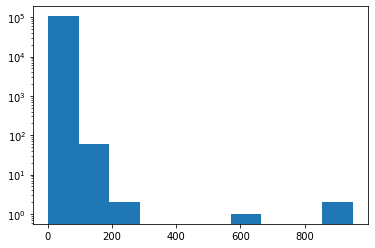

In [11]:
num_paper_per_author = conf_authors['author'].value_counts().values
plt.hist(num_paper_per_author, log=True)

It seems like there are a few outliers who have more papers than others, so we decided to check who are they.

In [12]:
conf_authors['author'].value_counts().head(10)

                           950
Sheila A. McIlraith        918
Satinder P. Singh (ed.)    663
Luc Van Gool               220
Toshio Fukuda              196
Thomas S. Huang            186
Michael I. Jordan          168
Trevor Darrell             158
Shuicheng Yan              154
Takeo Kanade               151
Name: author, dtype: int64

It turns out the author who has the most papers doesn't have a name. There must be some problems behind it, so we took a look at it.

In [13]:
conf_authors[conf_authors['author'] == ''].head()

,id,year,title,conference,author
21,conf/iccv/2007hci,2007,"Human-Computer Interaction, IEEE International...",iccv,
47,conf/iccv/2005hci,2005.0,"Computer Vision in Human-Computer Interaction,...",iccv,
357,conf/iccv/2005,<i>2005.0</i>,10th IEEE International Conference on Computer...,iccv,
366,conf/iccv/2011,2011.0,IEEE International Conference on Computer Visi...,iccv,
559,conf/iccv/1998,'98,Procedings of the Sixth International Conferen...,iccv,


In [14]:
conf_authors[conf_authors['author'] == ''].loc[21]['title']

'Human-Computer Interaction, IEEE International Workshop, HCI 2007, Rio de Janeiro, Brazil, October 20, 2007, Proceedings'

Sheila A. McIlraith is appearing in every 2018 aaai paper although he is not the author of any (we searched on dblp website). We guess maybe because he is the editor of it.

In [15]:
conf_authors[conf_authors['author'] == 'Sheila A. McIlraith']

,id,year,title,conference,author
34101,conf/aaai/2018w,2018.0,The Workshops of the The Thirty-Second AAAI Co...,aaai,Sheila A. McIlraith
35347,conf/aaai/McIlraithS00,'00,What Sensing Tells Us: Towards a Formal Theory...,aaai,Sheila A. McIlraith
35462,conf/aaai/McIlraith97,<em>1997.0</em>,Representing Actions and State Constraints in ...,aaai,Sheila A. McIlraith
38936,conf/aaai/2018,2018.0,Proceedings of the Thirty-Second AAAI Conferen...,aaai,Sheila A. McIlraith
81449,conf/ijcai/McIlraithA01,<i>2001.0</i>,Theorem Proving with Structured Theories.,ijcai,Sheila A. McIlraith
...,...,...,...,...,...
1062659,conf/aaai/WangYGWKZCTZJ18,2018.0,R3: Reinforced Ranker-Reader for Open-Domain Q...,aaai,Sheila A. McIlraith
1155691,conf/aaai/BondiFHKDCHIJTN18,2018.0,SPOT Poachers in Action: Augmenting Conservati...,aaai,Sheila A. McIlraith
1160767,conf/aaai/BallingerHSSWTM18,2018.0,DeepHeart: Semi-Supervised Sequence Learning f...,aaai,Sheila A. McIlraith
1367572,conf/aaai/KrishnaswamyRAS18,2018.0,A Predictive Analytics Methodology to Assess a...,aaai,Sheila A. McIlraith


It seems like that for some of the papers McIlraith is not the author (he's not in the id), so we looked into the id and checked whether he is the author or not.

In [16]:
conf_authors[conf_authors['author'].apply(lambda x: x == 'Sheila A. McIlraith') & conf_authors['id'].apply(lambda x: '18' in x)]

,id,year,title,conference,author
34101,conf/aaai/2018w,2018.0,The Workshops of the The Thirty-Second AAAI Co...,aaai,Sheila A. McIlraith
38936,conf/aaai/2018,2018.0,Proceedings of the Thirty-Second AAAI Conferen...,aaai,Sheila A. McIlraith
134324,conf/aaai/Lorini18,2018.0,In Praise of Belief Bases: Doing Epistemic Log...,aaai,Sheila A. McIlraith
134419,conf/aaai/Abhishek18,2018.0,FgER: Fine-Grained Entity Recognition.,aaai,Sheila A. McIlraith
134513,conf/aaai/Heule18,2018.0,Schur Number Five.,aaai,Sheila A. McIlraith
...,...,...,...,...,...
1062659,conf/aaai/WangYGWKZCTZJ18,2018.0,R3: Reinforced Ranker-Reader for Open-Domain Q...,aaai,Sheila A. McIlraith
1155691,conf/aaai/BondiFHKDCHIJTN18,2018.0,SPOT Poachers in Action: Augmenting Conservati...,aaai,Sheila A. McIlraith
1160767,conf/aaai/BallingerHSSWTM18,2018.0,DeepHeart: Semi-Supervised Sequence Learning f...,aaai,Sheila A. McIlraith
1367572,conf/aaai/KrishnaswamyRAS18,2018.0,A Predictive Analytics Methodology to Assess a...,aaai,Sheila A. McIlraith


we can see Sheila A. McIlraith isn't in the id of 'conf/aaai/Lorini18'.

Satinder P. Singh (ed.) is appearing in every 2017 aaai paper although he is not the author of any (we searched on dblp website). We guess maybe because he is also the editor of it.

In [17]:
conf_authors[conf_authors['author'] == 'Satinder P. Singh (ed.)']

,id,year,title,conference,author
36976,conf/aaai/2017,2017.0,Proceedings of the Thirty-First AAAI Conferenc...,aaai,Satinder P. Singh (ed.)
38242,conf/aaai/2017w,2017.0,The Workshops of the The Thirty-First AAAI Con...,aaai,Satinder P. Singh (ed.)
134421,conf/aaai/Luger17,2017.0,Beyond Mechanical Turk: Using Techniques from ...,aaai,Satinder P. Singh (ed.)
134437,conf/aaai/Beckers17,2017.0,AAAI: An Argument Against Artificial Intellige...,aaai,Satinder P. Singh (ed.)
134490,conf/aaai/Sheh17,2017.0,"""Why Did You Do That?"" Explainable Intelligent...",aaai,Satinder P. Singh (ed.)
...,...,...,...,...,...
855321,conf/aaai/KhandpurJNZLSAR17,2017.0,Determining Relative Airport Threats from News...,aaai,Satinder P. Singh (ed.)
856313,conf/aaai/PrakashZHDLQLF17,2017.0,Condensed Memory Networks for Clinical Diagnos...,aaai,Satinder P. Singh (ed.)
955570,conf/aaai/HuRMGBFMBE17,2017.0,Integrating Verbal and Nonvebval Input into a ...,aaai,Satinder P. Singh (ed.)
1053133,conf/aaai/RosuABCCFGLRS17,2017.0,Knowledge-Based Provision of Goods and Service...,aaai,Satinder P. Singh (ed.)


We might as well check are there any other authors who have (ed.) in their name (which should indicate they are the editors and not the author)

In [18]:
conf_authors[conf_authors['author'].apply(lambda x: '(ed.)' in x)]

,id,year,title,conference,author
36976,conf/aaai/2017,2017.0,Proceedings of the Thirty-First AAAI Conferenc...,aaai,Satinder P. Singh (ed.)
38242,conf/aaai/2017w,2017.0,The Workshops of the The Thirty-First AAAI Con...,aaai,Satinder P. Singh (ed.)
134421,conf/aaai/Luger17,2017.0,Beyond Mechanical Turk: Using Techniques from ...,aaai,Satinder P. Singh (ed.)
134437,conf/aaai/Beckers17,2017.0,AAAI: An Argument Against Artificial Intellige...,aaai,Satinder P. Singh (ed.)
134490,conf/aaai/Sheh17,2017.0,"""Why Did You Do That?"" Explainable Intelligent...",aaai,Satinder P. Singh (ed.)
...,...,...,...,...,...
855321,conf/aaai/KhandpurJNZLSAR17,2017.0,Determining Relative Airport Threats from News...,aaai,Satinder P. Singh (ed.)
856313,conf/aaai/PrakashZHDLQLF17,2017.0,Condensed Memory Networks for Clinical Diagnos...,aaai,Satinder P. Singh (ed.)
955570,conf/aaai/HuRMGBFMBE17,2017.0,Integrating Verbal and Nonvebval Input into a ...,aaai,Satinder P. Singh (ed.)
1053133,conf/aaai/RosuABCCFGLRS17,2017.0,Knowledge-Based Provision of Goods and Service...,aaai,Satinder P. Singh (ed.)


Ok, so it's just Satinder P. Singh(ed.), cause the total number is the same.

We should remove the above mentioned outliers.

In [19]:
new_conf_authors = conf_authors[conf_authors['author'].apply(lambda x: x != '')]
removed_ids_sheila = new_conf_authors[new_conf_authors['author'].apply(lambda x: x == 'Sheila A. McIlraith') & new_conf_authors['id'].apply(lambda x: '18' in x)]['id'].values
removed_ids_satinder = new_conf_authors[new_conf_authors['author'] == 'Satinder P. Singh (ed.)']['id'].values
new_conf_authors = new_conf_authors[new_conf_authors['id'].apply(lambda x: x not in removed_ids_sheila and x not in removed_ids_satinder)].copy()

In [20]:
new_conf_papers = conf_papers[conf_papers['authors'] != '[]']
new_conf_papers = new_conf_papers[new_conf_papers['id'].apply(lambda x: x not in removed_ids_sheila and x not in removed_ids_satinder)].copy()

In [21]:
# check if the number of papers are equal in these two dataframs
new_conf_papers.shape[0] == new_conf_authors['id'].unique().size

True

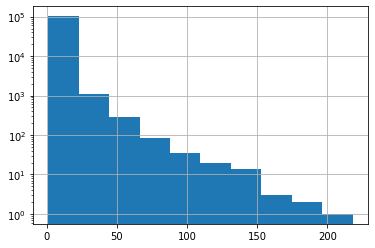

In [22]:
# plot the number of papers per author
num_paper_per_author = new_conf_authors['author'].value_counts().hist(log=True)

***A3.2***

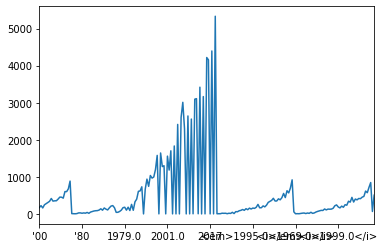

In [23]:
new_conf_papers['year'].value_counts().sort_index().plot()

The labels (x-axis) are clearly not all numbers, let's check what are the problems.

In [24]:
new_conf_papers['year'].value_counts().index.values

array(['2018.0', '2017.0', '2015.0', '2016.0', '2013.0', '2014.0',
       '2012.0', '2011.0', '2007.0', '2009.0', '2006.0', '2010.0',
       '2005.0', '2008.0', '2004.0', '2003.0', '1998.0', '1997.0',
       '2001.0', '2000.0', '1999.0', '1996.0', '2002.0', '1993.0',
       '1995.0', '1994.0', '1991.0', '<em>2018.0</em>', "'18",
       '<i>2018.0</i>', '1992.0', '1989.0', '<i>2017.0</i>',
       '<em>2017.0</em>', "'17", '1990.0', '<em>2015.0</em>', '1988.0',
       '<i>2015.0</i>', '1987.0', "'15", "'16", '<i>2016.0</i>',
       '<em>2016.0</em>', '<em>2013.0</em>', '?', '<i>2014.0</i>', "'12",
       '<i>2013.0</i>', "'13", '<i>2007.0</i>', '<em>2014.0</em>',
       '<em>2012.0</em>', "'14", '<em>2007.0</em>', '<i>2011.0</i>',
       "'07", '<i>2012.0</i>', '<em>2010.0</em>', '<i>2009.0</i>', "'11",
       '1986.0', '<em>2011.0</em>', '<i>2010.0</i>', '<em>2006.0</em>',
       "'10", "'09", '<em>2009.0</em>', '<em>2008.0</em>', "'08",
       '<i>2005.0</i>', "'06", '<em>2005.0</em>',

There are several problems.

First, there are some values in column year that do not just contain number but some invalid string (e.g. \<i>, \<em>).  
Second, some values are int values and some are float values (e.g. 2017, 2017.0).  
Third, some values only contain the last two digit or the last digit of the year (e.g. '71, '73).  
Last, there are some ? year.

We need to fix these problems.

In [25]:
def handle_errors(x, invalid_string):
    # remove invalid string
    x = x.strip()
    for tag in invalid_string:
        x = x.replace(tag, '')
    # handle ? year, we set it to nan now and will fill in the value in the next A3.4
    if x == '?':
        x = np.nan
    else:
        # make every year into a float value
        x = float(x)
    # convert it into four digits number
    if x < 100:
        # we set <19 because the newest paper is from 2018
        if x < 19:
            x += 2000
        else:
            x += 1900
    return x

invalid_string = ['<i>', '</i>', '<em>', '</em>', '\'']
new_conf_papers['year'] = new_conf_papers['year'].apply(handle_errors, invalid_string=invalid_string)

In [26]:
# apply the same function to new_conf_authors
new_conf_authors['year'] = new_conf_authors['year'].apply(handle_errors, invalid_string=invalid_string)

In [27]:
# check if the number of papers are equal in these two dataframs 
new_conf_papers.shape[0] == new_conf_authors['id'].unique().size

True

In [28]:
# check the modified year value
new_conf_papers['year'].value_counts().index.values

array([2018., 2017., 2015., 2016., 2013., 2014., 2012., 2011., 2007.,
       2009., 2010., 2006., 2005., 2008., 2004., 2003., 1998., 2001.,
       1997., 2000., 1999., 2002., 1996., 1993., 1995., 1994., 1991.,
       1992., 1989., 1990., 1988., 1987., 1986., 1985., 1983., 1981.,
       1979., 1977., 1975., 1984., 1982., 1980., 1973., 1971., 1969.])

There must be some problems for the ? year (now we get 630 papers with ? year which we turned it into NaN).

In [29]:
new_conf_papers[new_conf_papers.isna().any(axis=1)]

,id,authors,year,title,conference
62045,conf/nips/WangSJ11,"['Zuoguan Wang', 'Gerwin Schalk', 'Qiang Ji']",NaN,Anatomically Constrained Decoding of Finger Fl...,nips
62073,conf/nips/BachM10,"['Stephen H. Bach', 'Marcus A. Maloof']",NaN,A Bayesian Approach to Concept Drift.,nips
62077,conf/nips/RamkumarPHLL11,"['Pavan Ramkumar', 'Sebastian Pannasch', 'Bruc...",NaN,How Does the Brain Represent Visual Scenes? A ...,nips
62088,conf/nips/KolarBRS11,"['Mladen Kolar', 'Sivaraman Balakrishnan', 'Al...",NaN,Minimax Localization of Structural Information...,nips
62105,conf/nips/LempitskyZ10,"['Victor S. Lempitsky', 'Andrew Zisserman']",NaN,Learning To Count Objects in Images.,nips
...,...,...,...,...,...
70428,conf/nips/WangLSDC10,"['Eric Wang', 'Dehong Liu', 'Jorge G. Silva', ...",NaN,Joint Analysis of Time-Evolving Binary Matrice...,nips
70440,conf/nips/FroyenFS10,"['Vicky Froyen', 'Jacob Feldman', 'Manish Sing...",NaN,A Bayesian Framework for Figure-Ground Interpr...,nips
70451,conf/nips/BellalaBS10,"['Gowtham Bellala', 'Suresh K. Bhavnani', 'Cla...",NaN,Extensions of Generalized Binary Search to Gro...,nips
70466,conf/nips/AndersenMSHM11,"['Kasper Winther Andersen', 'Kristoffer Hougaa...",NaN,Identification of Functional Clusters in the S...,nips


In [30]:
new_conf_papers[new_conf_papers.isna().any(axis=1)]['year'].value_counts()

Series([], Name: year, dtype: int64)

***A3.3***

In [31]:
mlconf = ['icml', 'nips']
ml_papers = new_conf_papers[new_conf_papers['conference'].apply(lambda x: x in mlconf)]

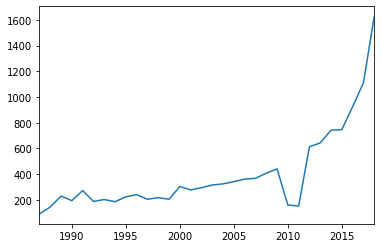

In [32]:
ml_papers['year'].value_counts().sort_index().plot()

There is something odd. The number of papers drops about 200 at around 2010 and 2011. Let's get back the orignial paper dataframe and find out what is causing this (we guessed that it could be the '?' year).

In [33]:
# use the orignial conf_papers and keep ml papers
ml_papers = conf_papers[conf_papers['conference'].apply(lambda x: x in mlconf)]
# check the number of data which has '?' year
ml_papers[ml_papers['year'] == '?'].shape[0]

509

In [34]:
# check how many are from 2010 and 2011 nips
ml_papers[ml_papers['year'] == '?'][ml_papers[ml_papers['year'] == '?']['id'].apply(lambda x: '11' in x or '10' in x and 'nips' in x).values]

,id,authors,year,title,conference
62045,conf/nips/WangSJ11,"['Zuoguan Wang', 'Gerwin Schalk', 'Qiang Ji']",?,Anatomically Constrained Decoding of Finger Fl...,nips
62073,conf/nips/BachM10,"['Stephen H. Bach', 'Marcus A. Maloof']",?,A Bayesian Approach to Concept Drift.,nips
62077,conf/nips/RamkumarPHLL11,"['Pavan Ramkumar', 'Sebastian Pannasch', 'Bruc...",?,How Does the Brain Represent Visual Scenes? A ...,nips
62088,conf/nips/KolarBRS11,"['Mladen Kolar', 'Sivaraman Balakrishnan', 'Al...",?,Minimax Localization of Structural Information...,nips
62105,conf/nips/LempitskyZ10,"['Victor S. Lempitsky', 'Andrew Zisserman']",?,Learning To Count Objects in Images.,nips
...,...,...,...,...,...
70423,conf/nips/KolterBN10,"['J. Zico Kolter', 'Siddharth Batra', 'Andrew ...",?,Energy Disaggregation via Discriminative Spars...,nips
70428,conf/nips/WangLSDC10,"['Eric Wang', 'Dehong Liu', 'Jorge G. Silva', ...",?,Joint Analysis of Time-Evolving Binary Matrice...,nips
70440,conf/nips/FroyenFS10,"['Vicky Froyen', 'Jacob Feldman', 'Manish Sing...",?,A Bayesian Framework for Figure-Ground Interpr...,nips
70451,conf/nips/BellalaBS10,"['Gowtham Bellala', 'Suresh K. Bhavnani', 'Cla...",?,Extensions of Generalized Binary Search to Gro...,nips


In [35]:
# see when and where the two other are from
ml_papers[ml_papers['year'] == '?'][~ml_papers[ml_papers['year'] == '?']['id'].apply(lambda x: '11' in x or '10' in x and 'nips' in x).values]

,id,authors,year,title,conference
62868,conf/nips/2008coa,[],?,Causality: Objectives and Assessment (NIPS 200...,nips
63309,conf/nips/2009mscts,[],?,Neural Information Processing Systems (NIPS) M...,nips


It turns out that the papers which have '?' year we previously deleted are mostly 2010 and 2011 nips papers (only 2 papers aren't from 2010 and 2011. They are from 2008 and 2009 nips respectively).

***A3.4***

In [36]:
# initiate BeautifulSoup
base_url = 'https://papers.nips.cc/'
r = get(base_url)
page_body = r.text
soup = BeautifulSoup(page_body, 'html.parser')

In [37]:
# find tags with href including /book/
all_nips_a = soup.find_all(href=re.compile('/book/'))
all_nips_links = []
# starting from 2018 to 1987
for nips_a in all_nips_a:
    all_nips_links.append(base_url + nips_a['href'][1:])

In [38]:
nips_papers_list = []
id_list = []
year = 2018
for link in all_nips_links:
    # initiate BeautifulSoup for website of each year's nips
    r = get(link)
    page_body = r.text
    soup = BeautifulSoup(page_body, 'html.parser')
    # skip the first one since it's actually not a paper entry
    all_papers_li = soup.find_all('li')[1:]
    for papers_li in all_papers_li:
        # find tags with href including /paper/ and get the title text
        title = papers_li.find(href=re.compile('/paper/')).text
        # find all anchor tags with class as author
        authors_a = papers_li.find_all('a', class_='author')
        # construct authors' list
        authors = [author.text for author in authors_a]
        # create id following how dblp does it
        if len(authors) != 0:
            idx = ''.join(['conf/nips/', authors[0].split(' ')[-1]] + [author.split(' ')[-1][0] for author in authors[1:]] + [str(year)[-2:]])
        else: # this is for paper with no author, will remove these afterward
            idx = 'conf/nips/'
        # handle duplicate idx (we realized there will be some papers which were written by the same authors in a year 
        # when building a new papers and authors df, so we must create a distinct id for that. We check how dblp does
        # it. The following block shows one example.)
        if idx in id_list:
            if ord(idx[-1]) >= 97:
                idx[-1] = chr(ord(idx[-1]) + 1)
            else:
                idx += 'a'
        # don't bother paper with no author
        if len(authors) != 0:
            id_list.append(idx)
        nips_papers_list.append({
            'id': idx,
            'authors': authors,
            'year': year,
            'title': title,
            'conference': 'nips'
        })
    year -= 1

In [39]:
# two papers with the same authors and yaer
ml_papers[ml_papers['id'].apply(lambda x: 'conf/nips/ZhouYF18' in x)]

,id,authors,year,title,conference
63325,conf/nips/ZhouYF18a,"['Pan Zhou', 'Xiaotong Yuan', 'Jiashi Feng']",<em>2018.0</em>,Efficient Stochastic Gradient Hard Thresholding.,nips
66809,conf/nips/ZhouYF18,"['Pan Zhou', 'Xiaotong Yuan', 'Jiashi Feng']",2018.0,New Insight into Hybrid Stochastic Gradient De...,nips


In [40]:
# create a pandas dataframe for the new nips data
nips_papers = pd.DataFrame.from_dict(nips_papers_list)
# remove paper with no author
nips_papers = nips_papers[nips_papers['id'] != 'conf/nips/']

In [41]:
import unicodedata
from string import punctuation
def remove_punct(text):
    return ''.join([ch for ch in text if ch not in punctuation])
def remove_accent(text):
    return unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")

In [42]:
def fill_missing_value(x):
    x_id = x['id']
    target_entry = nips_papers[nips_papers['id'] == x_id]
    if target_entry.empty:
        x_title = remove_accent(remove_punct(x['title']))
        target_entry = nips_papers[nips_papers['title'].apply(lambda y: remove_accent(remove_punct(y)) == x_title)]
    if not target_entry.empty:
        x['year'] = target_entry['year'].values[0]
    return x

new_conf_papers[new_conf_papers.isna().any(axis=1)] = new_conf_papers[new_conf_papers.isna().any(axis=1)].apply(fill_missing_value, axis=1)

In [43]:
new_conf_papers[new_conf_papers.isna().any(axis=1)]

,id,authors,year,title,conference
62077,conf/nips/RamkumarPHLL11,"['Pavan Ramkumar', 'Sebastian Pannasch', 'Bruc...",NaN,How Does the Brain Represent Visual Scenes? A ...,nips
62254,conf/nips/KwokCCMA11,"['Philip P. Kwok', 'Olga Ciccarelli', 'Declan ...",NaN,Predicting Clinically Definite Multiple Sclero...,nips
62378,conf/nips/ChangMJ11,"['Kai-min Kevin Chang', 'Brian Murphy', 'Marce...",NaN,A Latent Feature Analysis of the Neural Repres...,nips
62729,conf/nips/BahramisharifGSGH11,"['Ali Bahramisharif', 'Marcel A. J. van Gerven...",NaN,The Dynamic Beamformer.,nips
63244,conf/nips/GramfortVT11,"['Alexandre Gramfort', 'Gaël Varoquaux', 'Bert...",NaN,Beyond Brain Reading: Randomized Sparsity and ...,nips
63251,conf/nips/HaufeNNM11,"['Stefan Haufe', 'Vadim V. Nikulin', 'Guido No...",NaN,Pitfalls in EEG-Based Brain Effective Connecti...,nips
63701,conf/nips/BiessmannMLMM11,"['Felix Bießmann', 'Yusuke Murayama', 'Nikos K...",NaN,Non-separable Spatiotemporal Brain Hemodynamic...,nips
63783,conf/nips/DeligianniVTRSER11,"['Fani Deligianni', 'Gaël Varoquaux', 'Bertran...",NaN,Relating Brain Functional Connectivity to Anat...,nips
64374,conf/nips/MichelGEVT11,"['Vincent Michel', 'Alexandre Gramfort', 'Evel...",NaN,A Comparative Study of Algorithms for Intra- a...,nips
64497,conf/nips/HansenHM11,"['Toke Jansen Hansen', 'Lars Kai Hansen', 'Kri...",NaN,Decoding Complex Cognitive States Online by Ma...,nips


In [44]:
new_conf_papers[new_conf_papers.isna().any(axis=1)].shape[0]

32

There are still 32 papers with missing year, we'll remove them.  
We check most of the papers, they are not in this nips, but is in Machine Learning and Interpretation in Neuroimaging, which also has the abbreviation of nips.

In [45]:
new_conf_papers.dropna(inplace=True)

In [46]:
# recreate the author-centric dataframe
new_conf_authors = (new_conf_papers['authors']
                    .apply(lambda x: x.replace('[', '').replace(']', '').replace('\'', '').split(', ')).apply(pd.Series)
                    .merge(new_conf_papers, left_index=True, right_index=True)
                    .drop(['authors'], axis=1)
                    .melt(id_vars = ['id', 'year', 'title', 'conference'], value_name = "author")
                    .drop("variable", axis = 1)
                    .dropna(subset=['author']))

In [47]:
# check if the number of papers are equal in these two dataframs
new_conf_papers.shape[0] == new_conf_authors['id'].nunique()

True

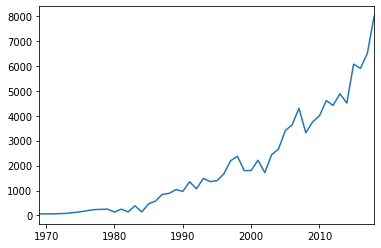

In [48]:
# redo A3.2
new_conf_papers['year'].value_counts().sort_index().plot()

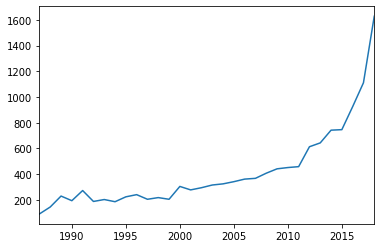

In [49]:
# redo A3.3
ml_papers = new_conf_papers[new_conf_papers['conference'].apply(lambda x: x in mlconf)]
ml_papers['year'].value_counts().sort_index().plot()

### A4. Author activity

For each author, calculate their normalized paper count, defined as the total number of papers divided by the author’s period of activity. An author’s period of activity is defined as the number of years between the earliest and latest papers of this author. Plot the distribution of the normalized paper count. What is the appropriate scale for the axes? Does the distribution (roughly) follow a particular law, and if yes, which one?

In [50]:
# group df by authors' names
new_conf_authors_grouped = new_conf_authors.groupby(new_conf_authors['author'])

In [51]:
normalized_paper_count = []

# go through all the groups
for author, group in new_conf_authors_grouped:
    # get total number of papers
    total_num_paper = group.shape[0]
    # get period of activity
    period_of_activity = group['year'].max() - group['year'].min() + 1
    normalized_paper_count.append(total_num_paper / period_of_activity)

(array([9.2342e+04, 1.0183e+04, 1.4170e+03, 3.0100e+02, 9.7000e+01,
        4.0000e+01, 1.3000e+01, 1.1000e+01, 4.0000e+00, 2.0000e+00]),
 array([ 0.05128205,  1.04615385,  2.04102564,  3.03589744,  4.03076923,
         5.02564103,  6.02051282,  7.01538462,  8.01025641,  9.00512821,
        10.        ]),
 <a list of 10 Patch objects>)

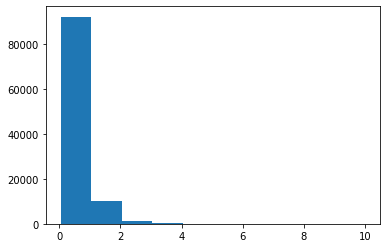

In [52]:
plt.hist(normalized_paper_count)

It roughly follows a log normal distribution.

# TODO!!!!

In [53]:
# save paper-centric and author-centric df
new_conf_papers.to_pickle('./data/conf_papers.pkl')
new_conf_authors.to_pickle('./data/conf_authors.pkl')

In [54]:
new_conf_papers = pd.read_pickle('./data/conf_papers.pkl')
new_conf_authors = pd.read_pickle('./data/conf_authors.pkl')

## Task B. Ranking authors

As you may know, there exist rankings for universities, which represent their relative quality and are used to compare the performance of different universities. In the same vein, there are rankings for conferences and journals, which represent the importance and impact of each conference or journal, and therefore allow for approximate comparisons. In this part, you will rank authors based on different aspects of their research output.

### B1. A Naïve Score

In the absence of citation counts, it is hard to objectively rank the authors based on the impact of their contributions to the field of AI research. A naïve way would be to rank them based on their number of published papers. Obtain such a ranking and analyze your result. Identify and explain some obvious limitations of this scheme.

In [55]:
naive_rank = new_conf_authors['author'].value_counts().to_frame().reset_index().rename(columns={'index': 'author', 'author': 'score'})

In [56]:
naive_rank.head()

,author,score
0,Luc Van Gool,218
1,Toshio Fukuda,196
2,Thomas S. Huang,186
3,Michael I. Jordan,168
4,Trevor Darrell,158


In [57]:
naive_rank.tail()

,author,score
104405,Ramkrishan K. Kumar,1
104406,Debanjan Mahata,1
104407,Wolfgang Hess,1
104408,Jianpeng Zhou,1
104409,Daniele Faccio,1


In [58]:
print('Number of author who has 1 paper:', naive_rank[naive_rank['score'] == 1].shape[0])
print('Number of author who has 2 paper:', naive_rank[naive_rank['score'] == 2].shape[0])

Number of author who has 1 paper: 62368
Number of author who has 2 paper: 16623


There are quite a lot author who has 1 or 2 papers. We can't really decide their ranking.  
Also, we don't know which conferences or journals they submitted to. Some conferences and journals are more impactful than others.

### B2. H5-index

Another way to score and rank authors could be based on the quality of the conferences and journals where they publish their papers. For this task, you have to use the H5-index score from AMiner (https://aminer.org/ranks/conf) (another database of scholarly publications), which captures the quality of academic conferences: the higher the H5-index, the better the conference.
1. Load the AMiner dataset ( *'aminer_ai.tsv'* available in the folder ``data/``), which contains H5-index values for AI conferences. Load it into a new Pandas dataframe, and join it with the author-centric DBLP dataframe.
2. Calculate a *'new'* author ranking (give each author a score, by which the authors are then sorted in order to obtain the ranking), where each author's score is the sum of the H5-indices of all their papers (the H5-index of a paper being the H5-index of the conference it is published in).
3. Analyze your new, H5-index-based author ranking and explain how and why your results are different from the previous ranking. Do you see any differences in the top-20 authors based on the H5-index-based ranking and the one produced using publication counts? If yes, list the authors that are ranked in the top 20 based on publication counts but absent in the top 20 based on the H5-index-based ranking. Identify the ranks of these authors in the ranking produced by the H5-index based ranking scheme.
4. Now, take the authors in the file `data/list_of_selected_authors.txt`, and compute their rankings using the two (naïve and H5-index-based) ranking schemes. What do you observe? Explain the potential dangers of the naïve, paper-count-based score.
5. On the flip side, do you see any potential dangers of using the H5-index-based score?   
_Hint: Analyze the conferences in which the top ranked authors publish. Investigate the effect of the conferences in which these authors publish more frequently on the obtained ranking._

***B2.1***

In [59]:
# load AMiner dataset and remove entry with no Short Name (nan)
aminer = pd.read_csv('./data/aminer_ai.csv', sep=';').dropna()
aminer['Short Name'] = aminer['Short Name'].apply(lambda x: x.lower())
aminer.head()

,Rank,Conference (Full Name),Short Name,H5-Index
0,1,IEEE Conference on Computer Vision and Pattern...,cvpr,112
1,2,IEEE Transactions on Pattern Analysis and Mach...,tpami,101
2,3,Expert Systems with Applications,expert syst. appl.,59
3,4,International Journal of Computer Vision,ijcv,58
4,5,IEEE International Conference on Robotics and ...,icra,58


In [60]:
h5_conf_authors = new_conf_authors.merge(aminer, left_on='conference', right_on='Short Name')

***B2.2***

In [61]:
h5_conf_authors_grouped = h5_conf_authors.groupby(h5_conf_authors['author'])

In [62]:
h5_rank = h5_conf_authors['author'].value_counts()
h5_rank -= h5_rank

# go through all the groups
for author, group in h5_conf_authors_grouped:
    for score in group['H5-Index']:
        h5_rank[author] += score

# turn it into a dataframe
h5_rank = h5_rank.sort_values(ascending=False).to_frame().reset_index().rename(columns={'index': 'author', 'author': 'score'})

***B2.3***

In [63]:
# naive rank
naive_rank.head(10)

,author,score
0,Luc Van Gool,218
1,Toshio Fukuda,196
2,Thomas S. Huang,186
3,Michael I. Jordan,168
4,Trevor Darrell,158
5,Shuicheng Yan,153
6,Takeo Kanade,151
7,Xiaoou Tang,148
8,Vijay Kumar 0001,143
9,Larry S. Davis,142


In [64]:
# h5 rank
h5_rank.head(10)

,author,score
0,Luc Van Gool,18607
1,Thomas S. Huang,14052
2,Xiaoou Tang,13102
3,Trevor Darrell,12763
4,Shuicheng Yan,12404
5,Toshio Fukuda,11368
6,Marc Pollefeys,11265
7,Larry S. Davis,11097
8,Martial Hebert,10629
9,Takeo Kanade,10569


Yes, these two rankings are different. We think the reason why this happens is kind of the reason we predicted in B1. Some conferences and journals are more impactful than others. if you publish a lot of papers in not so impactful (low h5-index score), you will get a high ranking in the naive ranking, but not in the h5-index ranking.

In [65]:
# find out authors that are ranked in the top 20 based on publication counts
# but absent in the top 20 based on the H5-index-based ranking
print('Authors who are not in top 20 of the new h5-index-based ranking:\n')
for name in naive_rank.head(20)['author']:
    if name not in h5_rank.head(20)['author'].values:
        print("{}. Rank {} in the new h5 ranking.".format(name, h5_rank[h5_rank['author'] == name].index.values[0] + 1))

Authors who are not in top 20 of the new h5-index-based ranking:

Vijay Kumar 0001. Rank 24 in the new h5 ranking.
Wolfram Burgard. Rank 31 in the new h5 ranking.
Dan Roth. Rank 61 in the new h5 ranking.
Eric P. Xing. Rank 33 in the new h5 ranking.
Roland Siegwart. Rank 28 in the new h5 ranking.
Christopher D. Manning. Rank 64 in the new h5 ranking.
Dan Klein. Rank 83 in the new h5 ranking.
Bernhard Schölkopf. Rank 39 in the new h5 ranking.


***B2.4***

In [66]:
# read the selected authors from list_of_selected_authors.txt file
# and save it into selected_authors list
selected_authors = []
with open('./data/list_of_selected_authors.txt', 'r') as f:
    for line in f.readlines():
        selected_authors.append(line.strip('\n'))

In [67]:
print('Author, Naive ranking, H5 ranking')
for name in selected_authors:
#     name = name.lower()
    n_ranking = naive_rank[naive_rank['author'] == name].index.values[0] + 1
    h_ranking = h5_rank[h5_rank['author'] == name].index.values[0] + 1
    print("{}, {}, {}".format(name, n_ranking, h_ranking))

Author, Naive ranking, H5 ranking
Parag Havaldar, 34893, 19586
Steffen Abraham, 37943, 19191
Yukihiro Nakamura, 35516, 19292
Iljung S. Kwak, 37365, 19373
Charles Freundlich, 36322, 18958
Mengjie Zhang, 3519, 22261
Naokazu Yokoya, 4106, 20816
Sebastian Otte, 4693, 21681
Jianwu Dang, 5357, 40966
Hy Murveit, 2328, 19340


We've observed that people who rank higher in naive ranking could rank lower in H5-index ranking.  
For example, Hy Murveit rank 2304 in naive ranking, but rank 19296 in H5-index ranking.

And people who rank lower in naive ranking could rank higher in H5-index ranking.
For example, Charles Freundlich rank 28245 in naive ranking, but rank 19611 in H5-index ranking.

Therefore, naïve, paper-count-based score is not reliable, because it doesn't take the importance of conferences and journals into consideration. If someone submit lots of paper in a less important conference, he will get a higher rank in this naive ranking with less impact than people who submit less paper but submit in a more important conference.

***B2.5***

In [68]:
h5_rank.head()

,author,score
0,Luc Van Gool,18607
1,Thomas S. Huang,14052
2,Xiaoou Tang,13102
3,Trevor Darrell,12763
4,Shuicheng Yan,12404


In [69]:
new_conf_authors[new_conf_authors['author'] == 'Luc Van Gool']['conference'].value_counts()

cvpr     132
iccv      46
accv      16
icra      10
nips       6
fgr        5
aaai       1
icann      1
icml       1
Name: conference, dtype: int64

We picked the number one ranked author Luc Van Gool. The top two conferences he published on are cvpr and iccv. They are all computer vision related conferences.

We thinked the potential danger of H5-index-based score is people who don't published on the conferences about current popular fields (e.g. computer vision) will be difficult to get higher score. But if a research field is not the most popular for now, it doesn't mean it is not as important as the popular one.

# TODO!!!!

### B3. And Justice For All

An ideal ranking scheme should not give undue advantage to authors who have been conducting research for a longer period of time and therefore have naturally published more papers when compared to a junior researcher. Does the ranking scheme designed by you in ``Step 2`` take this factor into account? If not, introduce variations in your ranking scheme to mitigate this effect. Do you observe anything odd with this new ranking? Clearly explain your observations.

_Hint: What you did in part A4 may be useful here._

The ranking scheme we designed in ``Step 2`` doesn't take this into account, so we introduced the period of activity from ``A4`` and tried to normalize the final score (score = sum of all the h5-index scores divided by the period of activity).

In [70]:
nor_h5_rank = h5_conf_authors['author'].value_counts()
nor_h5_rank -= nor_h5_rank

# go through all the groups
for author, group in h5_conf_authors_grouped:
    for score in group['H5-Index']:
        nor_h5_rank[author] += score
    # +1 is for people who published only in one year
    period_of_activity = group['year'].max() - group['year'].min() + 1
    nor_h5_rank[author] /= period_of_activity

# turn it into a dataframe
nor_h5_rank = nor_h5_rank.sort_values(ascending=False).to_frame().reset_index().rename(columns={'index': 'author', 'author': 'score'})

In [71]:
nor_h5_rank.head()

,author,score
0,Li Fei-Fei 0001,938
1,Xiaoou Tang,818
2,Shuicheng Yan,729
3,Jiashi Feng,684
4,Luc Van Gool,641


In [72]:
h5_rank.head()

,author,score
0,Luc Van Gool,18607
1,Thomas S. Huang,14052
2,Xiaoou Tang,13102
3,Trevor Darrell,12763
4,Shuicheng Yan,12404


In [79]:
new_conf_authors[new_conf_authors['author'].apply(lambda x: 'Li Fei-Fei' in x)]

,id,year,title,conference,author
202058,conf/iccv/GebruHF17,2017.0,Fine-Grained Recognition in the Wild: A Multi-...,iccv,Li Fei-Fei 0001
222279,conf/icra/AlahiWFS17,2017.0,Unsupervised camera localization in crowded sp...,icra,Li Fei-Fei 0001
241229,conf/cvpr/ChenLFG18,2018.0,Iterative Visual Reasoning Beyond Convolutions.,cvpr,Li Fei-Fei 0001
241231,conf/cvpr/GuptaJFSA18,2018.0,Social GAN: Socially Acceptable Trajectories W...,cvpr,Li Fei-Fei 0001
241411,conf/cvpr/ZhuLF17,2017.0,Knowledge Acquisition for Visual Question Answ...,cvpr,Li Fei-Fei 0001
245268,conf/cvpr/HuangLFN17,2017.0,Unsupervised Visual-Linguistic Reference Resol...,cvpr,Li Fei-Fei 0001
246241,conf/cvpr/JohnsonGF18,2018.0,Image Generation From Scene Graphs.,cvpr,Li Fei-Fei 0001
247470,conf/cvpr/JohnsonKF16,2016.0,DenseCap: Fully Convolutional Localization Net...,cvpr,Li Fei-Fei 0001
250233,conf/cvpr/HaqueAF16,2016.0,Recurrent Attention Models for Depth-Based Per...,cvpr,Li Fei-Fei 0001
301202,conf/iccv/GuptaJAF17,2017.0,Characterizing and Improving Stability in Neur...,iccv,Li Fei-Fei 0001


The top ranked author in the normallized ranking is Li Fei-Fei 0001. It's odd that the name contains some number.  

We searched the name on dblp and found out that the number is for disambiguation, because there are authors who have the same name. But in this dataset, it seems like there are only Li Fei-Fei 0001.

# TODO!!!!

## Task C. Trending topics

Historically, the field of AI has witnessed research in two broad flavors: “symbolic” (logic, planning, control, etc.) vs. “connectionist” (neural networks, deep learning, Bayesian methods, etc.). Let’s see if we can see how the popularity of these two approaches to AI is reflected in the DBLP data.

To this end, construct two dataframes: ``symbolic`` and ``connectionist``. ``symbolic`` is your cleaned paper-centric dataframe from part A (after fixing everything per the task description) filtered down to those papers whose titles contain at least one of the following words (not differentiating between upper and lower case letters): “logic”, “planning”, “control”; ``connectionist`` is a dataframe constructed in a similar manner, but with the words “deep”, “learning”, “feature”, “bayesian”. Plot the number of papers per year for ``symbolic`` and ``connectionist`` separately (i.e., 2 plots).
1. Describe the trends you observe. Based on these plots alone, what might one conclude about the popularity of the two approaches to AI?
2. Moving beyond these plots, what do you, as a careful data scientist, conclude about the popularity of symbolic vs. connectionist AI? Corroborate your reasoning with further plots.

_Note: You could use the text handling utilities below to clean the text in the paper titles._

In [74]:
# Text handling utilities
from string import punctuation
stopwords_list = open('data/stopwords.txt', 'r').readlines()
stopwords_list = [x.strip() for x in stopwords_list]
def stopword_remover(text):
    text_list = text.split()
    text_list = [x for x in text_list if x not in stopwords_list]
    return ' '.join(text_list)
def lowercase_all(text):
    return text.lower()
def remove_punct(text):
    return ''.join([ch for ch in text if ch not in punctuation])

In [75]:
# clean text in the paper titles
clean_conf_papers = new_conf_papers.copy()
clean_conf_papers['title'] = clean_conf_papers['title'].apply(stopword_remover).apply(lowercase_all).apply(remove_punct)

In [76]:
clean_conf_papers['title'].head()

0    object recognition using feature search strate...
1                          threedimensional scene flow
2    fluid motion recovery coupling dense parametri...
3    qualitative 3d shape reconstruction using dist...
4    gplac generalizing visionbased robotic skills ...
Name: title, dtype: object

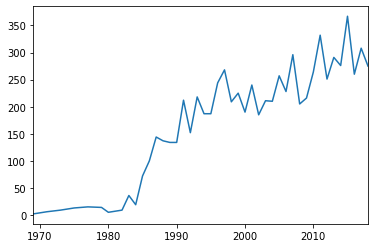

In [77]:
def detect_words(x, words_list):
    det = [word in words_list for word in x.split(' ')]
    return bool(sum(det))

words_symbolic = ['logic', 'planning', 'control']
symbolic = clean_conf_papers[clean_conf_papers['title'].apply(detect_words, words_list=words_symbolic)]

symbolic['year'].value_counts().sort_index().plot()

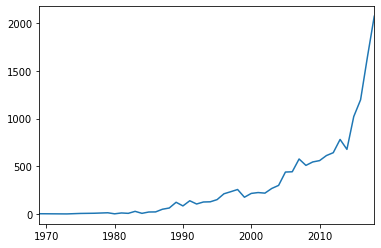

In [78]:
words_connectionist = ['deep', 'learning', 'feature', 'bayesian']
connectionist = clean_conf_papers[clean_conf_papers['title'].apply(detect_words, words_list=words_connectionist)]

connectionist['year'].value_counts().sort_index().plot()

According to these two plots, we conclude that the growth of "symbolic" field bas slow down and almost saturtate (the number of paper stays the same in recent years).

As for the "connectionist" field, it is growing faster and faster, almost like a exponential growth.

# TODO!!!!